In [1]:
# %matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
mpl.use('Agg')
from matplotlib import pyplot as plt
import math
import scipy.optimize as optimize
from scipy import r_

E1F_E0 = 5.497
E16_E0 = 5.754
E1F_LUM = 19.8e6 #19.844e6
E16_LUM = 28.1e6

PI = 3.14159265358979312
FSC = 0.00729735253
A = FSC
NA = 6.02214129E23
QE = 1.60217646E-19
MP = 0.93827203
MOMEGA = 0.78265
WOMEGA = 0.00849
BR = 0.891

def nu(w, q2):
    return (w*w-MP*MP+q2)/(2*MP)

def epsilon(w, q2, e0):
    n = nu(w, q2)
    e1 = e0-n
    epsInv = 1+2*(q2+n*n)/(4*e0*e1-q2)
    return 1.0/epsInv


def vgflux(w, q2, e0):
    eps = epsilon(w, q2, e0)
    return A*w*(w*w-MP*MP)/(4*PI*e0*e0*MP*MP*q2*(1-eps))


def xbjork(w, q2):
    return q2/(2*MP*nu(w, q2))

def w_from_xb(xb, q2):
    return (MP**2+q2*(1/xb-1))**0.5

def get_kfac(W):
    m, M = MOMEGA, MP
    return 1/((1/(2*W)*math.sqrt(m**4-2*m**2*M**2-2*m**2*W**2+M**4-2*M**2*W**2+W**4))/((W**2-M**2)/(2*W)))

def interp_nn(h, ibin0):
    iL,iR = 0,0
    vL,vR = 0,0
    eL,eR = 0,0
    for ibin in range(ibin0+1,h.GetNbinsX()+1):
        v,e = h.GetBinContent(ibin),h.GetBinError(ibin)
        if v!=0:
            iR = ibin
            vR = v
            eR = e
            break
    for ibin in reversed(range(1,ibin0)):
        v,e = h.GetBinContent(ibin),h.GetBinError(ibin)
        if v!=0:
            iL = ibin
            vL = v
            eL = e
            break
    vL = vR if iL==0 else vL
    vR = vL if iR==0 else vR
    e = (eL**2+eR**2)**0.5
    if vL == vR:
        return (vL, e)
    else:
        #y = y1+m(x-x1)
        m = (vR-vL)/(iR-iL)
        return (vL+m*(ibin0-iL), e)

def w8d_Q2_mean(Q2_0, Q2_1):
    n = math.log(Q2_1)-math.log(Q2_0)
    d = 1/Q2_0-1/Q2_1
    return n/d

def combined_fit(_df, p, verbose=False):
    _df6 = _df[['phi','dxs_6','dxs_err_6']].dropna()
    _dff = _df[['phi','dxs_f','dxs_err_f']].dropna()
    x1, x2, y1, y2 = _df6.phi.values, _dff.phi.values, _df6.dxs_6.values, _dff.dxs_f.values
    y1e, y2e = _df6.dxs_err_6, _dff.dxs_err_f
    eps_f = _df.eps_f.unique()[0]
    eps_l_f = _df.eps_l_f.unique()[0]
    eps_6 = _df.eps_6.unique()[0]
    eps_l_6 = _df.eps_l_6.unique()[0]
    pw = _df.pwcms.unique()[0]
    kg = _df.peecms.unique()[0]
    
    rfs_6 = lambda x, r0, rtt, rlt: pw/kg*(r0 + rtt*eps_6*np.cos(2*x) + rlt*np.sqrt(2*eps_l_6*(1+eps_6))*np.cos(x))
    rfs_f = lambda x, r0, rtt, rlt: pw/kg*(r0 + rtt*eps_f*np.cos(2*x) + rlt*np.sqrt(2*eps_l_f*(1+eps_f))*np.cos(x))

    def rfs_cost(p, x1, y1, x2, y2, y1e, y2e):
        return r_[
            (rfs_6(x1, p[0], p[2], p[3])-y1)/y1e,
            (rfs_f(x2, p[1], p[2], p[3])-y2)/y2e
        ]

    if y1e is None:
        y1e = len(y1)*[1]
    if y2e is None:
        y1e = len(y2)*[1]
    result = optimize.leastsq(rfs_cost, p, args=(x1,y1,x2,y2,y1e,y2e), full_output=verbose)
    
    return (result, rfs_6, rfs_f)

In [2]:
df_e16_dxs = pd.read_pickle('df_e16_dxs.pickle')
df_e1f_dxs = pd.read_pickle('df_e1f_dxs.pickle')
df_e16_dxs['vgflux'] = df_e16_dxs.apply(lambda x: vgflux(x.W, x.Q2, E16_E0), axis=1)
df_e1f_dxs['vgflux'] = df_e1f_dxs.apply(lambda x: vgflux(x.W, x.Q2, E1F_E0), axis=1)
for df in [df_e16_dxs, df_e1f_dxs]:
    df['peecms'] = (np.power(df.W,2)-MP**2)/(2*df.W)
    df['pwcms'] = 1/(2*df.W)*np.sqrt(MOMEGA**4-2*MOMEGA**2*MP**2-2*MOMEGA**2*np.power(df.W,2)+MP**4-2*MP**2*np.power(df.W,2)+np.power(df.W,4))
names_join = ['Q2r0', 'Q2r1', 'Wr0', 'Wr1', 'nu', 'peecms', 'pwcms', 'Q2', 'W', 'cost', 'phi']
df = df_e16_dxs.sort_values(by=names_join).reset_index()
df = df.merge(df_e1f_dxs.sort_values(by=names_join).reset_index(),
              on=names_join, suffixes=['_6', '_f'], how='outer')

In [3]:
df = df.applymap(lambda x: x if x!=0 else np.NaN)

In [ ]:
1850-2200_2200-2220_rf_fits.pdf

In [8]:
rflist = []
# Q2r0, Q2r1 = 2.2, 2.5
# Wr0, Wr1 = 1.84, 1.86
for Q2r0 in [1.85]: #df.Q2r0.unique()[:2]:
#     for Wr0 in df[df.Q2r0==Q2r0].Wr0.unique()[10:20]:
    for Wr0 in [2.2]:
        fig, axes = plt.subplots(3,4, sharex=True, sharey='row',
                                 figsize=(6.5,4),
                                 gridspec_kw={'wspace':0,'hspace':0})
        df1q2w = df[(df.Q2r0==Q2r0)&(df.Wr0==Wr0)]
        Q2r1 = df1q2w.Q2r1.values[0]
        Wr1 = df1q2w.Wr1.values[0]
        costs = [round(x,1) for x in np.arange(-0.9, 1, 0.2)]
        fig.axes[0].set_xlim(-PI,PI)

        for (cost,ax) in zip(costs,fig.axes[:10]):
            _df = df1q2w[df1q2w.cost==cost]
            results, rfs_6, rfs_f = combined_fit(_df, r_[400,400,0,0])

            ax.errorbar(_df.phi.values,
                        _df.dxs_6.values,
                        _df.dxs_err_6.values,
                        fmt='go', markersize=5, fillstyle='none')
            ax.errorbar(_df.phi.values,
                        _df.dxs_f.values,
                        _df.dxs_err_f.values,
                        fmt='b^', markersize=5)
            r0_6, r0_f, rtt, rlt = results[0]
            X = np.linspace(-PI, PI, 100)
            Y6 = [rfs_6(x, r0_6,rtt,rlt) for x in X]
            ax.plot(X,Y6,'k-')
            Yf = [rfs_f(x, r0_f,rtt,rlt) for x in X]
            ax.plot(X,Yf,'k-')
            ax.grid()
            
        #     
        #first col
        for ax in [axes[i][0] for i in range(0,len(axes))]:
            ax.set_yticks(ax.get_yticks()[1:-1])
        #last row
        for ax in [axes[-1][0]]:
            ax.set_xlabel(r'$\phi^*$ $(rad)$')
            ax.set_ylabel(r'$\frac{d^2\sigma_h}{d\Omega^\star}$ ($\frac{nb}{sr})$',
                          fontsize=12)
        for ax in fig.axes:
            ax.tick_params(axis='both', which='major', labelsize=8)
            ax.set_xticks([-2,-1,0,1,2])

        ax = axes[-1][-1]
        texp = ax.text(0, 0.8,
                'Q$^2$ = [%.3f,%.3f) GeV$^2$ \n W = [%.2f,%.2f) GeV'%(Q2r0,Q2r1,Wr0,Wr1),
                fontsize=12, #fontweight='bold',
                horizontalalignment='center',
                verticalalignment='top',
                transform=ax.transAxes)
        texp.set_bbox(dict(color='white'))
        fnps = [1000*x for x in [Q2r0,Q2r1,Wr0,Wr1]]
        res = results[1]
        r0_6, r0_f, rtt, rlt = results[0]
        rflist.append((Q2r0,Q2r1,Wr0,Wr1,res,r0_6, r0_f, rtt, rlt))
        fig.savefig('/home/ephelps/tmp/%d-%d_%d-%d_rf_fits.pdf'%(fnps[0],fnps[1],fnps[2],fnps[3]), bbox_inches='tight')

In [14]:
rflist

[(1.8500000000000001,
  2.2000000000000002,
  1.7200000000000002,
  1.7400000000000002,
  1,
  462.60639861365871,
  715.30023439678644,
  183.0499130690275,
  182.89376937891714),
 (1.8500000000000001,
  2.2000000000000002,
  1.7400000000000002,
  1.76,
  1,
  753.87467782052875,
  730.22396263317523,
  -100.62613451995169,
  9.0989720077636171),
 (2.2000000000000002,
  2.5,
  1.7200000000000002,
  1.7400000000000002,
  1,
  427.24687322458675,
  427.01230268175112,
  -96.58524628104864,
  125.13098202521726),
 (2.2000000000000002,
  2.5,
  1.7400000000000002,
  1.76,
  1,
  596.16755847251636,
  651.47245624995662,
  46.044383511786485,
  -12.322058442223939)]

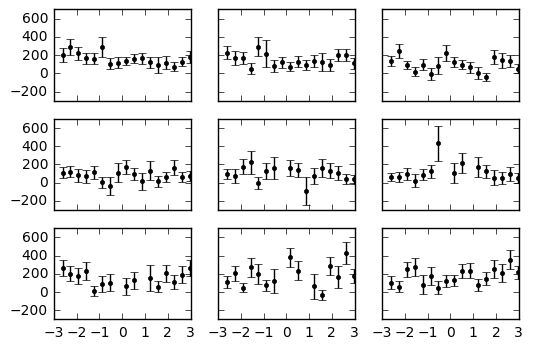

In [4]:
fig, axes = plt.subplots(2,5, sharex=True, sharey=True)
df1q2w = df[(df.Q2r0==2.2)&(df.Wr0==1.84)]
costs = [round(x,1) for x in np.arange(-0.9, 1, 0.2)]
for (cost,ax) in zip(costs,fig.axes):
    _df = df1q2w[df1q2w.cost==cost]
    
    ax.errorbar(_df.phi.values,
                _df.dxs_f.values,
                _df.dxs_err_f.values,
                fmt='k.')

In [5]:
def rfs(phi, eps, eps_l, pw, kg, r_o, r_tt, r_tl):
    return pw/kg*(r_o + eps*r_tt*np.cos(2*phi) +
                  np.sqrt(2*eps_l*(1+eps))*np.cos(phi))
    

In [12]:
_df = _df.dropna()
X = _df.phi.dropna().values
Y = _df.dxs_f.dropna().values
E = _df.dxs_err_f.dropna().values
eps = _df.eps_f
eps_l = _df.eps_l_f
pw = _df.pwcms
kg = _df.peecms

# popt, pcov = optimize.curve_fit(rfs,X,Y,sigma=E,
#                                 absolute_sigma=True)

In [6]:
class Parameter:
    def __init__(self, value):
            self.value = value

    def set(self, value):
            self.value = value

    def __call__(self):
            return self.value

def fit(function, parameters, y, x = None, x0 = None):
    def f(params):
        i = 0
        for p in parameters:
            p.set(params[i])
            i += 1
        return y - function(x)

    if x is None: x = np.arange(y.shape[0])
    p = [param() for param in parameters]
    return optimize.leastsq(f, p)

In [12]:
eps = _df.eps_f.unique()[0]
eps_l = _df.eps_l_f.unique()[0]
pw = _df.pwcms.unique()[0]
kg = _df.peecms.unique()[0]

R_0 = Parameter(400)
R_TT = Parameter(200)
R_LT = Parameter(0)

def rfs(x):
    return pw/kg*(R_0() + R_TT()*eps*np.cos(2*x) +
                  R_LT()*np.sqrt(2*eps_l*(1+eps))*np.cos(x))

result = fit(rfs, [R_0, R_TT, R_LT], _df.dxs_f, _df.phi.values)

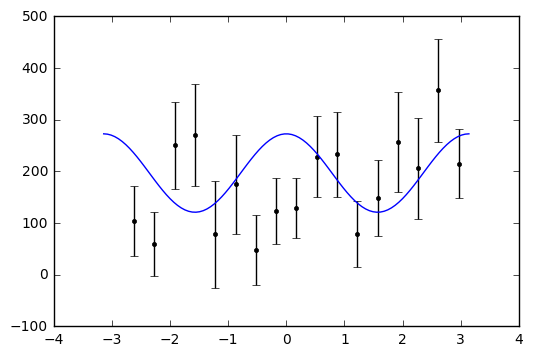

In [13]:
plt.errorbar(_df.phi.values,
            _df.dxs_f.values,
            _df.dxs_err_f.values,
            fmt='k.')
X = np.linspace(-PI, PI, 100)
Y = [rfs(x) for x in X]
plt.plot(X,Y)

In [14]:
result

(array([ 400.,  200.,    0.]), 4)

In [48]:
def combined_fit(_df, p, verbose=False):
    _df6 = _df[['phi','dxs_6']].dropna()
    _dff = _df[['phi','dxs_f']].dropna()
    x1, x2, y1, y2 = _df6.phi.values, _dff.phi.values, _df6.dxs_6.values, _dff.dxs_f.values
    eps_f = _df.eps_f.unique()[0]
    eps_l_f = _df.eps_l_f.unique()[0]
    eps_6 = _df.eps_6.unique()[0]
    eps_l_6 = _df.eps_l_6.unique()[0]
    pw = _df.pwcms.unique()[0]
    kg = _df.peecms.unique()[0]
#     print(eps_f, eps_l_f, eps_6, eps_l_6, pw, kg)
#     R_0 = 200
#     R_TT = 0
#     R_LT = 0
#     p = r_[R_0, R_TT, R_LT]
    
    rfs_6 = lambda x, r0, rtt, rlt: pw/kg*(r0 + rtt*eps_6*np.cos(2*x) + rlt*np.sqrt(2*eps_l_6*(1+eps_6))*np.cos(x))
    rfs_f = lambda x, r0, rtt, rlt: pw/kg*(r0 + rtt*eps_f*np.cos(2*x) + rlt*np.sqrt(2*eps_l_f*(1+eps_f))*np.cos(x))

    def rfs_cost(p, x1, y1, x2, y2):
        return r_[
            rfs_6(x1, p[0], p[1], p[2])-y1,
            rfs_f(x2, p[0], p[1], p[2])-y2
        ]

    result = optimize.leastsq(rfs_cost, p, args=(x1,y1,x2,y2), full_output=verbose)
    
    return (result, rfs_6, rfs_f)

In [67]:
def combined_fit(_df, p, verbose=False):
    _df6 = _df[['phi','dxs_6','dxs_err_6']].dropna()
    _dff = _df[['phi','dxs_f','dxs_err_f']].dropna()
    x1, x2, y1, y2 = _df6.phi.values, _dff.phi.values, _df6.dxs_6.values, _dff.dxs_f.values
    y1e, y2e = _df6.dxs_err_6, _dff.dxs_err_f
    eps_f = _df.eps_f.unique()[0]
    eps_l_f = _df.eps_l_f.unique()[0]
    eps_6 = _df.eps_6.unique()[0]
    eps_l_6 = _df.eps_l_6.unique()[0]
    pw = _df.pwcms.unique()[0]
    kg = _df.peecms.unique()[0]
    
    rfs_6 = lambda x, r0, rtt, rlt: pw/kg*(r0 + rtt*eps_6*np.cos(2*x) + rlt*np.sqrt(2*eps_l_6*(1+eps_6))*np.cos(x))
    rfs_f = lambda x, r0, rtt, rlt: pw/kg*(r0 + rtt*eps_f*np.cos(2*x) + rlt*np.sqrt(2*eps_l_f*(1+eps_f))*np.cos(x))

    def rfs_cost(p, x1, y1, x2, y2, y1e, y2e):
        return r_[
            (rfs_6(x1, p[0], p[2], p[3])-y1)/y1e,
            (rfs_f(x2, p[1], p[2], p[3])-y2)/y2e
        ]

    if y1e is None:
        y1e = len(y1)*[1]
    if y2e is None:
        y1e = len(y2)*[1]
    result = optimize.leastsq(rfs_cost, p, args=(x1,y1,x2,y2,y1e,y2e), full_output=verbose)
    
    return (result, rfs_6, rfs_f)

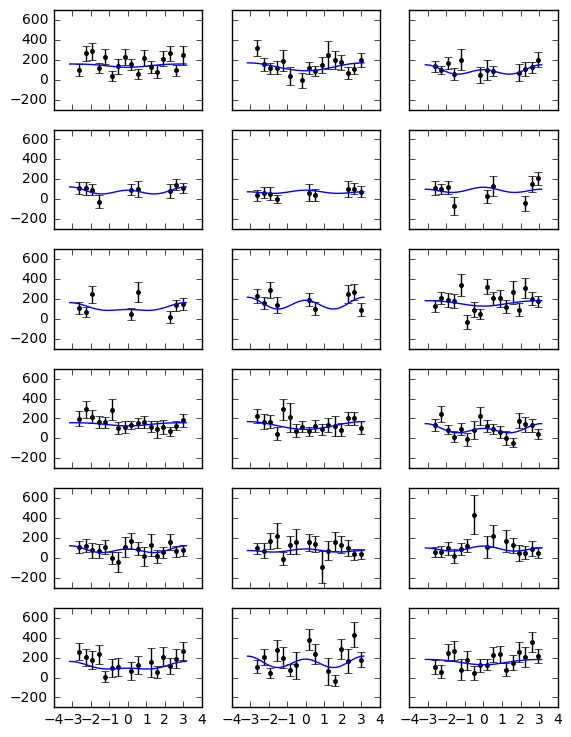

In [52]:
fig, axes = plt.subplots(6,3, sharex=True, sharey=True, figsize=(6.5,9))
df1q2w = df[(df.Q2r0==2.2)&(df.Wr0==1.84)]
costs = [round(x,1) for x in np.arange(-0.7, 1, 0.2)]
for (cost,ax_6,ax_f) in zip(costs,fig.axes[:9],fig.axes[9:]):
    _df = df1q2w[df1q2w.cost==cost]
    results, rfs_6, rfs_f = combined_fit(_df, r_[400,0,0])
    
    ax_6.errorbar(_df.phi.values,
                _df.dxs_6.values,
                _df.dxs_err_6.values,
                fmt='k.')
    ax_f.errorbar(_df.phi.values,
                _df.dxs_f.values,
                _df.dxs_err_f.values,
                fmt='k.')
    
    X = np.linspace(-PI, PI, 100)
    Y = [rfs_6(x, *results[0]) for x in X]
    ax_6.plot(X,Y)
    Y = [rfs_f(x, *results[0]) for x in X]
    ax_f.plot(X,Y)

/home/ephelps/projects/anaconda2/envs/root6_py3/lib/python3.4/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


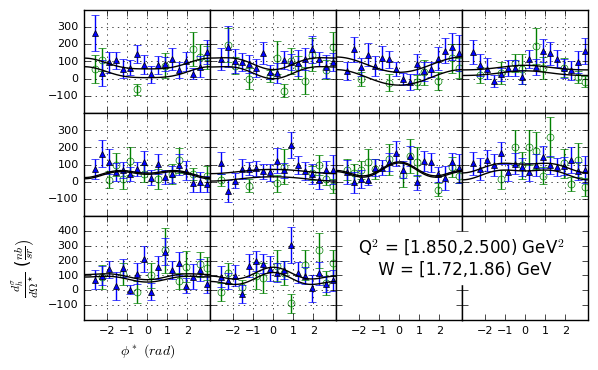

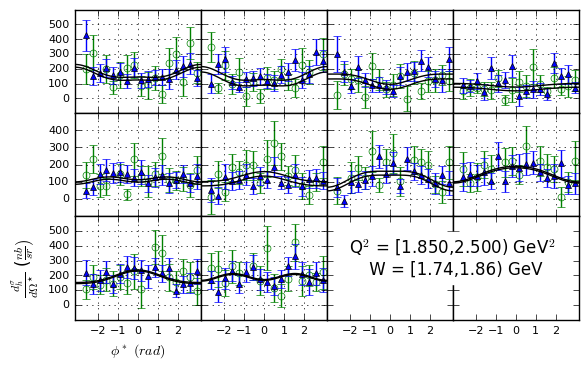

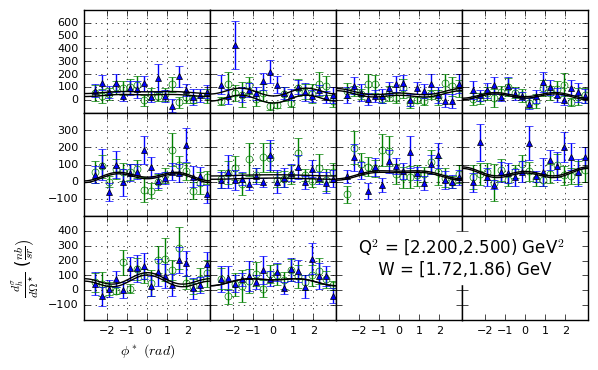

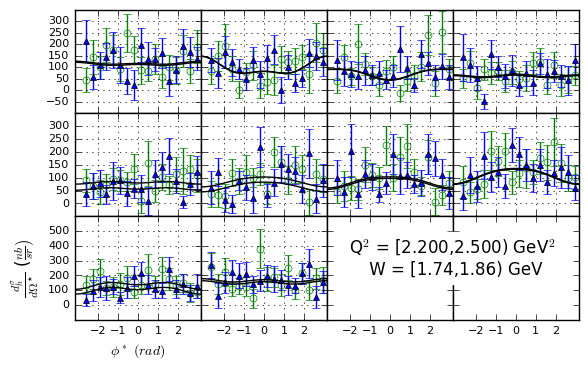

In [135]:
Q2r0, Q2r1 = 2.2, 2.5
Wr0, Wr1 = 1.84, 1.86
mpl.use('Agg')
for Q2r0 in df.Q2r0.unique()[:2]:
    for Wr0 in df[df.Q2r0==Q2r0].Wr0.unique()[:2]:
        fig, axes = plt.subplots(3,4, sharex=True, sharey='row',
                                 figsize=(6.5,4),
                                 gridspec_kw={'wspace':0,'hspace':0})
        df1q2w = df[(df.Q2r0==Q2r0)&(df.Wr0==Wr0)]
        costs = [round(x,1) for x in np.arange(-0.9, 1, 0.2)]
        fig.axes[0].set_xlim(-PI,PI)

        for (cost,ax) in zip(costs,fig.axes[:10]):
            _df = df1q2w[df1q2w.cost==cost]
            results, rfs_6, rfs_f = combined_fit(_df, r_[400,400,0,0])

            ax.errorbar(_df.phi.values,
                        _df.dxs_6.values,
                        _df.dxs_err_6.values,
                        fmt='go', markersize=5, fillstyle='none')
            ax.errorbar(_df.phi.values,
                        _df.dxs_f.values,
                        _df.dxs_err_f.values,
                        fmt='b^', markersize=5)
            r0_6, r0_f, rtt, rlt = results[0]
            X = np.linspace(-PI, PI, 100)
            Y6 = [rfs_6(x, r0_6,rtt,rlt) for x in X]
            ax.plot(X,Y6,'k-')
            Yf = [rfs_f(x, r0_f,rtt,rlt) for x in X]
            ax.plot(X,Yf,'k-')
            ax.grid()
        #     
        #first col
        for ax in [axes[i][0] for i in range(0,len(axes))]:
            ax.set_yticks(ax.get_yticks()[1:-1])
        #last row
        for ax in [axes[-1][0]]:
            ax.set_xlabel(r'$\phi^*$ $(rad)$')
            ax.set_ylabel(r'$\frac{d^\sigma_h}{d\Omega^\star}$ ($\frac{nb}{sr})$',
                          fontsize=12)
        for ax in fig.axes:
            ax.tick_params(axis='both', which='major', labelsize=8)
            ax.set_xticks([-2,-1,0,1,2])

        ax = axes[-1][-1]
        texp = ax.text(0, 0.8,
                'Q$^2$ = [%.3f,%.3f) GeV$^2$ \n W = [%.2f,%.2f) GeV'%(Q2r0,Q2r1,Wr0,Wr1),
                fontsize=12, #fontweight='bold',
                horizontalalignment='center',
                verticalalignment='top',
                transform=ax.transAxes)
        texp.set_bbox(dict(color='white'))
        fnps = [1000*x for x in [Q2r0,Q2r1,Wr0,Wr1]]
        fig.savefig('/home/ephelps/tmp/%d-%d_%d-%d_rf_fits.pdf'%(fnps[0],fnps[1],fnps[2],fnps[3]), bbox_inches='tight')